In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data=pd.read_csv('train.csv')
data.head(10)
#data.describe()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


C:\Users\brian\AppData\Local\Temp\ipykernel_18844\696955322.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), cmap="YlGnBu")


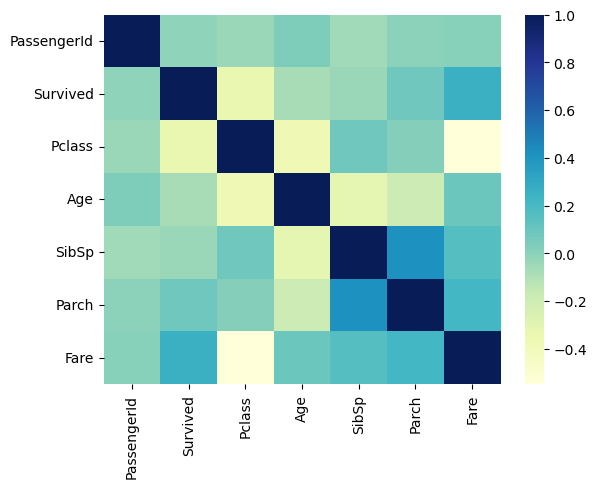

In [3]:
import seaborn as sns
sns.heatmap(data.corr(), cmap="YlGnBu")
plt.show()

<Axes: >

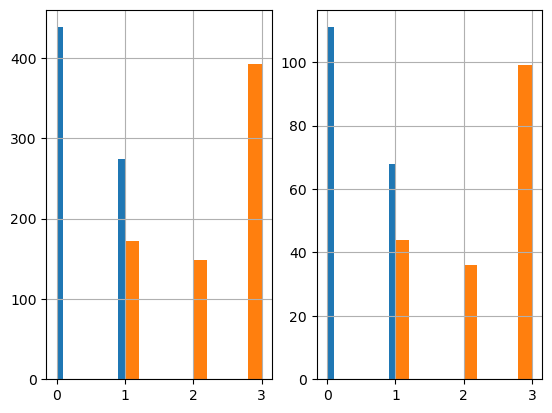

In [4]:
#cette partie du test permet de diviser les données en deux une partie pour l'entrainement et une autre partie pour le test
from sklearn.model_selection import StratifiedShuffleSplit 
split=StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indices, test_indices in split.split(data, data[["Survived", "Pclass", "Sex"]]):
    strat_train_set=data.loc[train_indices]
    strat_test_set=data.loc[test_indices]
plt.subplot(1, 2, 1) #histogrammes sur une ligne, deux colonnes , ligne 1
strat_train_set["Survived"].hist()
strat_train_set["Pclass"].hist()
 
plt.subplot(1, 2, 2) #histogrammes sur une ligne , deux colonnes , ligne 2
strat_test_set["Survived"].hist()
strat_test_set["Pclass"].hist()

In [5]:
#verrification des valeur du dataset
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 824 to 133
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          571 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        165 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [6]:
#on remarque que plusieur inforamtion manquent , nous allon essayer de les estimer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, Y=None):
        return self
    def transform(self, X):
        imputer=SimpleImputer(strategy="mean")
        X['Age']=imputer.fit_transform(X[['Age']])
        return X
    
        
        



In [7]:
# a present nous allons remplacer les valeur string en binaire pour les attributs dont c'est possible
from sklearn.preprocessing import OneHotEncoder
class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, Y=None):
        return self
    def transform(self, X):
        encoder=OneHotEncoder()
        matrix=encoder.fit_transform(X[['Embarked']]).toarray()
        column_names=["C", "S", "Q", "N"]
        for i in range(len(matrix.T)):
            X[column_names[i]]=matrix.T[i]
        
        matrix=encoder.fit_transform(X[["Sex"]]).toarray()
        column_names=["Female", "Male"]
        for i in range(len(matrix.T)):
            X[column_names[i]]=matrix.T[i]
        
        return X
            
        
        


In [9]:
#dans cette partie nous allons supprimer les attributs dont on a trop de valeur manquante
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, Y=None):
        return self
    def transform(self, X):
        return X.drop(["Embarked", "Name", "Ticket", "Cabin", "Sex", "N"], axis=1, errors="ignore")
        
    

In [10]:
#on creee un pipeline qui va s'occuper de faire toutes les transformations voulues sur notre data set
from sklearn.pipeline import Pipeline
pipeline=Pipeline([("ageimputer", AgeImputer()),
                    ("featureencoder", FeatureEncoder()), 
                    ("featuredropper", FeatureDropper())])


In [11]:
strat_train_set=pipeline.fit_transform(strat_train_set) #: applique toutes nos modification au data set
strat_train_set


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
824,825,0,3,2.00000,4,1,39.6875,0.0,0.0,1.0,0.0,1.0
424,425,0,3,18.00000,1,1,20.2125,0.0,0.0,1.0,0.0,1.0
151,152,1,1,22.00000,1,0,66.6000,0.0,0.0,1.0,1.0,0.0
868,869,0,3,29.98979,0,0,9.5000,0.0,0.0,1.0,0.0,1.0
189,190,0,3,36.00000,0,0,7.8958,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
347,348,1,3,29.98979,1,0,16.1000,0.0,0.0,1.0,1.0,0.0
80,81,0,3,22.00000,0,0,9.0000,0.0,0.0,1.0,0.0,1.0
72,73,0,2,21.00000,0,0,73.5000,0.0,0.0,1.0,0.0,1.0
733,734,0,2,23.00000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0


In [29]:
#mise des données à la même echelle pour eviter qu'une seule valeur n'influence trop les resultats du modèle
from sklearn.preprocessing import StandardScaler
Y_data=strat_train_set["Survived"]
X_data=strat_train_set.drop(["Survived"], axis=1)
scaler=StandardScaler()
X_data=scaler.fit_transform(X_data)
Y_data=Y_data.to_numpy()

In [31]:
#creation du modèle test  en utilisant les données d'entrainement splittés
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf=RandomForestClassifier()
param_grid={"n_estimators": [10, 100, 200, 500], "max_depth": [None, 5, 10], "min_samples_split": [2, 3, 4]}
grid_search=GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data, Y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [10, 100, 200, 500]},
             return_train_score=True, scoring='accuracy')

In [ ]:
final_clf

In [52]:
final_clf=grid_search.best_estimator_

In [57]:
final_clf

RandomForestClassifier(max_depth=5, min_samples_split=3)

In [69]:
#strat_test_set=pipeline.fit_transform(strat_test_set) comme score très proche de 1, on valide le modèle
Y=strat_test_set["Survived"]
X=strat_test_set.drop(['Survived'], axis=1)
scaler=StandardScaler()
X_data=scaler.fit_transform(X)
Y_data=Y.to_numpy()
final_clf.score(X_data, Y_data) #coefficient de correspondances entre les données d'entrainement et les données de tes pour le modèle

0.8324022346368715

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
877,878,0,3,"Petroff, Mr. Nedelio",male,19.0,0,0,349212,7.8958,NaN,S
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C
40,41,0,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40.0,1,0,7546,9.4750,NaN,S
728,729,0,2,"Bryhl, Mr. Kurt Arnold Gottfrid",male,25.0,1,0,236853,26.0000,NaN,S
552,553,0,3,"O'Brien, Mr. Timothy",male,NaN,0,0,330979,7.8292,NaN,Q


In [26]:
final_data=pipeline.fit_transform(data) #ajustement des données totales
final_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,1,0,3,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.000000,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
887,888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
888,889,0,3,29.699118,1,2,23.4500,0.0,0.0,1.0,1.0,0.0
889,890,1,1,26.000000,0,0,30.0000,1.0,0.0,0.0,0.0,1.0


In [27]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Age          891 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   C            891 non-null    float64
 8   S            891 non-null    float64
 9   Q            891 non-null    float64
 10  Female       891 non-null    float64
 11  Male         891 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 83.7 KB


In [28]:
X_final=final_data.drop(['Survived'],axis=1)
Y_final=final_data["Survived"]
scaler=StandardScaler()
X_final_data=scaler.fit_transform(X_final)
Y_final_data=Y_final.to_numpy()


NameError: name 'StandardScaler' is not defined

In [89]:
prod_clf=RandomForestClassifier() #creation du modèle finale a partie de toutes les données fournies
param_grid={"n_estimators": [10, 100, 200, 500], "max_depth": [None, 5, 10], "min_samples_split": [2, 3, 4]}
grid_search=GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_final_data, Y_final_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [10, 100, 200, 500]},
             return_train_score=True, scoring='accuracy')

In [91]:
prod_final_clf=grid_search.best_estimator_
prod_final_clf

RandomForestClassifier(max_depth=5)

In [97]:
titanic_test_data=pd.read_csv("test.csv") #acquisition des données de testé du modèle
titanic_test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [100]:
#titanic_test_data=pipeline.fit_transform(titanic_test_data) #normalisation des données

titanic_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         417 non-null    float64
 6   C            418 non-null    float64
 7   S            418 non-null    float64
 8   Q            418 non-null    float64
 9   Female       418 non-null    float64
 10  Male         418 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 36.0 KB


In [101]:
x_final_test=titanic_test_data 
x_final_test=x_final_test.fillna(method="ffill")#finallisation des données pour le modèle
scaler=StandardScaler()
x_data_final_test=scaler.fit_transform(x_final_test)

In [102]:
prediction=prod_final_clf.predict(x_data_final_test) #application du modèle pour obtenir le resultat

In [103]:
prediction

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [105]:
final_df=pd.DataFrame(titanic_test_data["PassengerId"])
final_df["Survived"]=prediction
final_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [107]:
result=pd.read_csv("gender_submission.csv")
result

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [108]:
x1=result["PassengerId"].to_numpy()

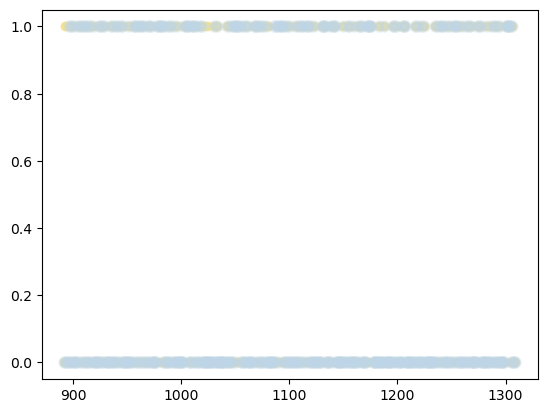

In [109]:
y1=result["Survived"].to_numpy()
x2=final_df["PassengerId"].to_numpy()
y2=final_df["Survived"].to_numpy()
plt.scatter(x1, y1, color='#F4E291');
plt.scatter(x2, y2, color='#BDD5EA50', linewidth=3)
plt.show()

In [12]:
new_data=strat_train_set

In [13]:
new_data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
824,825,0,3,2.00000,4,1,39.6875,0.0,0.0,1.0,0.0,1.0
424,425,0,3,18.00000,1,1,20.2125,0.0,0.0,1.0,0.0,1.0
151,152,1,1,22.00000,1,0,66.6000,0.0,0.0,1.0,1.0,0.0
868,869,0,3,29.98979,0,0,9.5000,0.0,0.0,1.0,0.0,1.0
189,190,0,3,36.00000,0,0,7.8958,0.0,0.0,1.0,0.0,1.0


In [14]:
new_target=new_data["Survived"]
new_feature=new_data.drop(["Survived"], axis=1)

In [21]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ShuffleSplit, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

cv=ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)


prod_clf=RandomForestClassifier() #creation du modèle finale a partie de toutes les données fournies
param_grid={"n_estimators": [10, 100, 200], "min_samples_split": [2, 3, 4]}
grid_search=GridSearchCV(prod_clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(new_feature, new_target)

cv_results = cross_validate(
    grid_search, new_feature, new_target, cv=cv, scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=2
)


In [22]:
cv_results = pd.DataFrame(cv_results)
cv_results.head()


,fit_time,score_time,test_score,train_score
0,6.800568,0.017170,-0.258741,-0.031634
1,7.016614,0.018379,-0.181818,-0.026362
2,7.935005,0.022841,-0.209790,-0.005272
3,7.809031,0.012575,-0.195804,-0.019332
4,8.909524,0.016670,-0.202797,-0.000000


<Axes: ylabel='Frequency'>

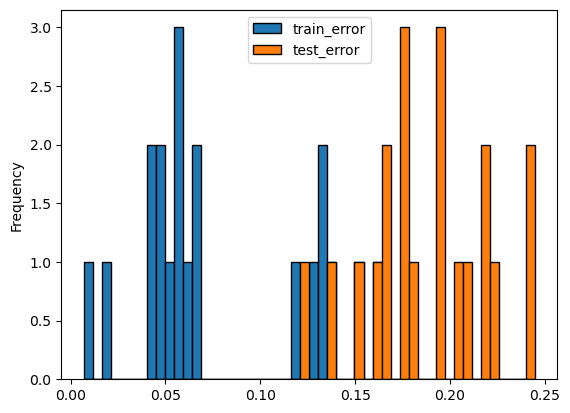

In [19]:
import matplotlib.pyplot as plt
scores=pd.DataFrame()
scores[["train_error", "test_error"]]=-cv_results[["train_score", "test_score"]]
scores.plot.hist(bins=50, edgecolor="black")

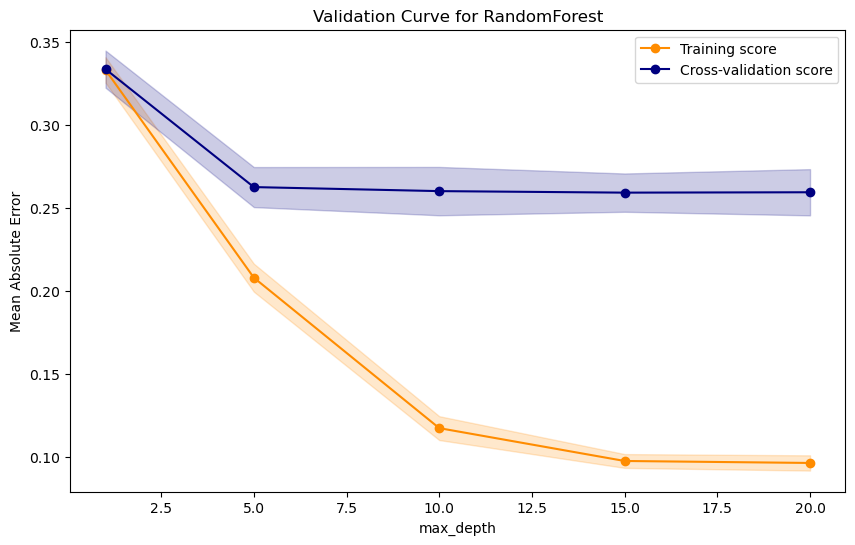

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import validation_curve

# Assuming 'new_feature' and 'new_target' are your feature and target datasets
param_name = "max_depth"
param_range = np.array([1, 5, 10, 15, 20])
cv = 5  # Number of cross-validation folds

# Create a RandomForestRegressor
rf_model = RandomForestRegressor()

# Generate validation curve
train_scores, test_scores = validation_curve(
    rf_model, new_feature, new_target,
    param_name=param_name,
    param_range=param_range,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=1
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.title("Validation Curve for RandomForest")
plt.xlabel(f"{param_name}")
plt.ylabel("Mean Absolute Error")

plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", marker='o')
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="darkorange")

plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy", marker='o')
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="navy")

plt.legend(loc="best")
plt.show()

In [49]:
!pip install --upgrade scikit-learn
